In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

In [15]:
# 1. CHARGEMENT DES DONNÉES

img_left = cv2.imread('data/04_Maurener_Weg_8_000003_000120_leftImg8bit.jpg', 0)
img_right = cv2.imread('data/04_Maurener_Weg_8_000003_000120_rightImg8bit.jpg', 0)
disp_gt_raw = cv2.imread('data/04_Maurener_Weg_8_000003_000120_disparity.png', cv2.IMREAD_UNCHANGED)

with open('data/04_Maurener_Weg_8_000003_000120_camera.json', 'r') as f:
    camera_data = json.load(f)

fx = camera_data['intrinsic']['fx']
baseline = camera_data['extrinsic']['baseline']

print(f"Image left shape: {img_left.shape}")
print(f"Image right shape: {img_right.shape}")
print(f"Disparity GT shape: {disp_gt_raw.shape}")
print(f"fx: {fx}, baseline: {baseline}m")

Image left shape: (320, 640)
Image right shape: (320, 640)
Disparity GT shape: (1024, 2048)
fx: 2268.36, baseline: 0.222126m


In [22]:
# 2. CALCUL DE LA DISPARITÉ AVEC STEREOSGBM

# Paramètres StereoSGBM
min_disp = 0                    # Disparité minimale
num_disp = 16 * 10              # Nombre de disparités (DOIT être divisible par 16)
                                # 160 = recherche de 0 à 160 pixels de décalage
block_size = 5                  # Taille du bloc de matching (impair, 3-11 typique)

# Créer l'objet StereoSGBM
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    P1=8 * 3 * block_size**2,   # Pénalité pour petits changements de disparité
    P2=32 * 3 * block_size**2,  # Pénalité pour grands changements
    disp12MaxDiff=1,            # Max différence left-right check
    uniquenessRatio=10,         # Filtre unicité (10-15%)
    speckleWindowSize=100,      # Taille fenêtre pour filtre speckle
    speckleRange=32,            # Variation max dans fenêtre speckle
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY  # Mode 3-way pour meilleure qualité
)

# CALCUL DE LA DISPARITÉ !
disparity_raw = stereo.compute(img_left, img_right)
# Convertir en float et normaliser (résultat en pixels × 16)
disparity = disparity_raw.astype(np.float32) / 16.0

print(f"Disparité calculée: min={disparity.min():.2f}, max={disparity.max():.2f}")



Disparité calculée: min=-1.00, max=159.00


In [23]:
# 3. POST-TRAITEMENT DE LA DISPARITÉ

disparity_valid = disparity.copy()
disparity_valid[disparity_valid <= 0] = np.nan  


In [24]:
# 4. CALCUL DE LA PROFONDEUR Z

# Formule: Z = (fx × baseline) / disparité
depth = (fx * baseline) / disparity_valid

print(f"Profondeur: min={np.nanmin(depth):.2f}m, max={np.nanmax(depth):.2f}m")


Profondeur: min=3.17m, max=895.75m


In [25]:
# 5. PRÉPARATION DE LA GROUND TRUTH (RESIZE)

# Décoder la disparité GT (encodée en int16)
disp_gt = disp_gt_raw.astype(np.float32) / 256.0

target_height, target_width = img_left.shape
print(f"\nResize GT de {disp_gt.shape} vers ({target_height}, {target_width})...")

disp_gt_resized = cv2.resize(disp_gt, (target_width, target_height), 
                             interpolation=cv2.INTER_LINEAR)

# Ajuster les valeurs de disparité après resize
# Ratio de resize pour corriger les valeurs
scale_x = target_width / disp_gt.shape[1]
disp_gt_resized = disp_gt_resized * scale_x  # Disparité doit être scalée aussi !

print(f"Scale factor appliqué: {scale_x:.4f}")

# Masquer pixels invalides dans GT
disp_gt_valid = disp_gt_resized.copy()
disp_gt_valid[disp_gt_valid <= 0] = np.nan

print(f"GT shape après resize: {disp_gt_valid.shape}")
print(f"GT disparité: min={np.nanmin(disp_gt_valid):.2f}, max={np.nanmax(disp_gt_valid):.2f}")


Resize GT de (1024, 2048) vers (320, 640)...
Scale factor appliqué: 0.3125
GT shape après resize: (320, 640)
GT disparité: min=0.00, max=39.38


In [26]:
# 6. COMPARAISON: CALCUL DES MÉTRIQUES

# Masque des pixels valides dans les DEUX cartes
valid_mask = (~np.isnan(disparity_valid)) & (~np.isnan(disp_gt_valid))

# Erreur absolue
error = np.abs(disparity_valid - disp_gt_valid)
mae = np.nanmean(error[valid_mask])

# Bad pixel percentage (erreur > 3 pixels)
bad_pixels = np.sum(error[valid_mask] > 3)
bad_pixel_ratio = (bad_pixels / np.sum(valid_mask)) * 100

# RMSE
rmse = np.sqrt(np.nanmean((error[valid_mask])**2))


print(f"MAE (Mean Absolute Error): {mae:.2f} pixels")
print(f"RMSE: {rmse:.2f} pixels")
print(f"Bad Pixels (>3px): {bad_pixel_ratio:.2f}%")
print(f"Pixels valides comparés: {np.sum(valid_mask):,}")


MAE (Mean Absolute Error): 0.64 pixels
RMSE: 2.72 pixels
Bad Pixels (>3px): 4.50%
Pixels valides comparés: 125,464


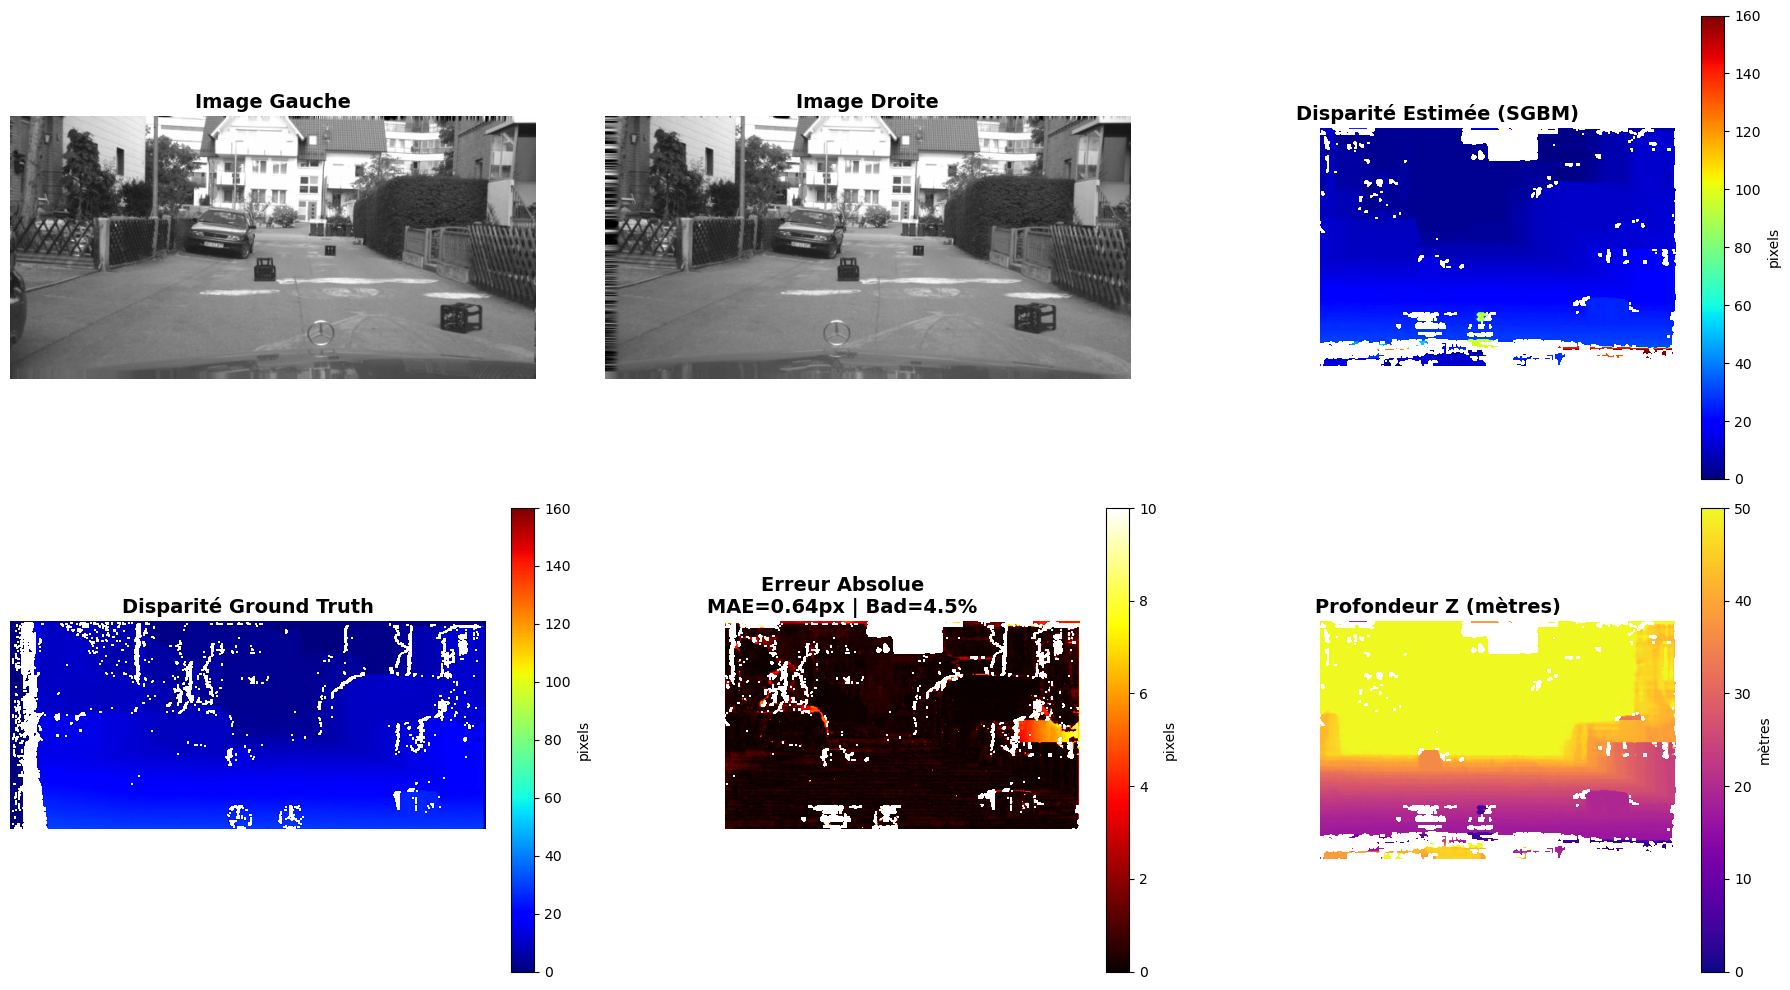

In [27]:
# 7. VISUALISATION

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Image gauche
axes[0, 0].imshow(img_left, cmap='gray')
axes[0, 0].set_title('Image Gauche', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Image droite
axes[0, 1].imshow(img_right, cmap='gray')
axes[0, 1].set_title('Image Droite', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Disparité estimée
im1 = axes[0, 2].imshow(disparity_valid, cmap='jet', vmin=0, vmax=num_disp)
axes[0, 2].set_title(f'Disparité Estimée (SGBM)', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')
plt.colorbar(im1, ax=axes[0, 2], label='pixels', fraction=0.046)

# Disparité Ground Truth
im2 = axes[1, 0].imshow(disp_gt_valid, cmap='jet', vmin=0, vmax=num_disp)
axes[1, 0].set_title('Disparité Ground Truth', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')
plt.colorbar(im2, ax=axes[1, 0], label='pixels', fraction=0.046)

# Carte d'erreur
im3 = axes[1, 1].imshow(error, cmap='hot', vmin=0, vmax=10)
axes[1, 1].set_title(f'Erreur Absolue\nMAE={mae:.2f}px | Bad={bad_pixel_ratio:.1f}%', 
                     fontsize=14, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im3, ax=axes[1, 1], label='pixels', fraction=0.046)

# Profondeur Z
im4 = axes[1, 2].imshow(depth, cmap='plasma', vmin=0, vmax=50)
axes[1, 2].set_title('Profondeur Z (mètres)', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')
plt.colorbar(im4, ax=axes[1, 2], label='mètres', fraction=0.046)

plt.tight_layout()
plt.savefig('disparity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

